In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from keras.layers import Bidirectional  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(Bidirectional(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [ ]:
# load dataset
series = read_csv('/content/drive/MyDrive/Dataset Flood Forecasting/Average Data/stage_mean.csv', index_col='Date')

In [ ]:
series

,Avg Stage
Date,
1965-01-01,203.239696
1965-01-02,203.239696
1965-01-03,203.239696
1965-01-04,203.239696
1965-01-05,203.239696
...,...
2020-11-28,205.204429
2020-11-29,205.205143
2020-11-30,205.216572


In [ ]:
series.head()

,Avg Stage
Date,
1965-01-01,203.239696
1965-01-02,203.239696
1965-01-03,203.239696
1965-01-04,203.239696
1965-01-05,203.239696


In [ ]:
series.shape

(20425, 1)

In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [ ]:
raw_values

array([[203.23969637],
       [203.23969637],
       [203.23969637],
       ...,
       [205.2165718 ],
       [203.97172322],
       [203.95886607]])

In [ ]:
diff_values

0                          [0.0]
1                          [0.0]
2                          [0.0]
3                          [0.0]
4                          [0.0]
                  ...           
20419    [0.0007142857143662695]
20420     [0.000714285714224161]
20421     [0.011428571428552914]
20422      [-1.2448485828568607]
20423    [-0.012857142857114923]
Length: 20424, dtype: object

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [ ]:
supervised

,0,0
0,0,[0.0]
1,[0.0],[0.0]
2,[0.0],[0.0]
3,[0.0],[0.0]
4,[0.0],[0.0]
...,...,...
20419,[-0.01062028707991658],[0.0007142857143662695]
20420,[0.0007142857143662695],[0.000714285714224161]
20421,[0.000714285714224161],[0.011428571428552914]
20422,[0.011428571428552914],[-1.2448485828568607]


In [ ]:
print(supervised_values)

[[0 array([0.])]
 [array([0.]) array([0.])]
 [array([0.]) array([0.])]
 ...
 [array([0.00071429]) array([0.01142857])]
 [array([0.01142857]) array([-1.24484858])]
 [array([-1.24484858]) array([-0.01285714])]]


In [ ]:
supervised_values.shape

(20424, 2)

In [ ]:
# split data into train and test-sets
train, test = supervised_values[0:16340], supervised_values[16340:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
len(train_scaled)

16340

In [ ]:
len(test_scaled)

4084

In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()

In [ ]:
expected=[]

In [ ]:

for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected.append(raw_values[len(train) + i + 1])
	expected_temp = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected_temp))

Month=1, Predicted=205.931473, Expected=205.955000
Month=2, Predicted=205.973695, Expected=206.016429
Month=3, Predicted=206.059759, Expected=206.152143
Month=4, Predicted=206.246499, Expected=206.360714
Month=5, Predicted=206.490670, Expected=206.389286
Month=6, Predicted=206.354191, Expected=206.361429
Month=7, Predicted=206.353959, Expected=206.412857
Month=8, Predicted=206.460442, Expected=206.465000
Month=9, Predicted=206.486797, Expected=206.336429
Month=10, Predicted=206.217459, Expected=206.367857
Month=11, Predicted=206.451272, Expected=206.372857
Month=12, Predicted=206.337959, Expected=206.355000
Month=13, Predicted=206.355600, Expected=206.331429
Month=14, Predicted=206.310816, Expected=206.270000
Month=15, Predicted=206.226501, Expected=206.190714
Month=16, Predicted=206.142068, Expected=206.082143
Month=17, Predicted=206.010373, Expected=206.027857
Month=18, Predicted=206.013645, Expected=205.975714
Month=19, Predicted=205.937068, Expected=205.930000
Month=20, Predicted=2

In [ ]:
len(expected)

4084

In [ ]:
len(predictions)

4084

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(expected, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.075


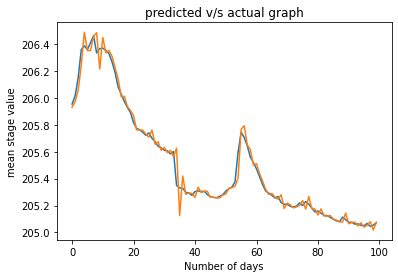

In [ ]:
# line plot of observed vs predicted
pyplot.xlabel("Number of days")
pyplot.ylabel("mean stage value")
pyplot.title("predicted v/s actual graph")
pyplot.plot(expected[:100])
pyplot.plot(predictions[:100])
pyplot.plot()
pyplot.show()

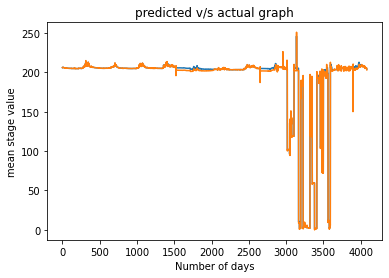

In [ ]:
# line plot of observed vs predicted
pyplot.xlabel("Number of days")
pyplot.ylabel("mean stage value")
pyplot.title("predicted v/s actual graph")
pyplot.plot(expected)
pyplot.plot(predictions)
pyplot.plot()
pyplot.show()

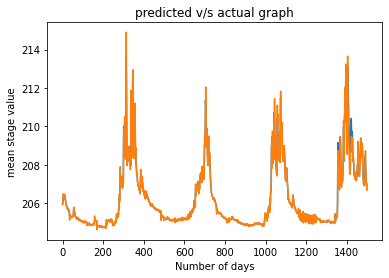

In [ ]:
pyplot.xlabel("Number of days")
pyplot.ylabel("mean stage value")
pyplot.title("predicted v/s actual graph")
pyplot.plot(expected[:1500])
pyplot.plot(predictions[:1500])
pyplot.plot()
pyplot.show()